In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# **1. Importación de librerías necesarias**
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# **2. Cargar los datos**
data = pd.read_csv('/content/drive/MyDrive/Airbnb/airbnb_us.csv')

# Vista preliminar de los datos
print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
         id property_type        room_type  \
0  13418779         House  Entire home/apt   
1   3808709     Apartment  Entire home/apt   
2  12422935     Apartment     Private room   
3    180792         House     Private room   
4   2658946     Apartment  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   
1  {TV,Internet,"Wireless Internet","Air conditio...             2        1.0   
2  {TV,"Wireless Internet",Heating,"Smoke detecto...             2        1.0   
3  {TV,"Cable TV","Wireless Internet","Pets live ...             2        1.0   
4  {TV,"Cable TV",Internet,"Wireless Internet","A...             6        1.5   

   bed_type cancellation_policy  cleaning_fee city  ...   longitude  \
0  Real Bed            flexible          True   SF  ... -122.431619   
1  Real Bed            moderate          True   DC  ...  -77.03459

In [4]:
# **3. Preprocesamiento de los datos**

# a. Eliminar columnas irrelevantes
columns_to_drop = ['id', 'name', 'thumbnail_url', 'zipcode', 'longitude', 'latitude', 'amenities', 'description', 'neighbourhood', 'cleaning_fee', 'cancellation_policy']
data = data.drop(columns=columns_to_drop, errors='ignore')

# b. Limpieza y transformación de la columna `price`
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# c. Separar variables predictoras (X) y objetivo (y)
X = data.drop('price', axis=1)
y = data['price']

# d. Identificar variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Variables categóricas:", categorical_features)
print("Variables numéricas:", numerical_features)

Variables categóricas: ['property_type', 'room_type', 'bed_type', 'city', 'first_review', 'host_has_profile_pic', 'host_identity_verified', 'host_response_rate', 'host_since', 'instant_bookable', 'last_review']
Variables numéricas: ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']


In [5]:
# **4. Configuración del preprocesador de datos**

# a. Transformaciones para variables numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# b. Transformaciones para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# c. Combinación de transformaciones en un `ColumnTransformer`
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [6]:
# **5. Construcción de modelos**

# a. Pipeline con RandomForest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0))
])

# b. Pipeline con SVR
svr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=100, epsilon=0.2))
])

# c. Pipeline con PCA y RandomForest
pca_rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0))
])

In [7]:
# **6. División de datos en entrenamiento y prueba**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Función para evaluar un modelo
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo):
    modelo.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = modelo.predict(X_test)  # Predicciones
    r2 = r2_score(y_test, y_pred)  # R²
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    print(f"\nEvaluación del modelo {nombre_modelo}:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    return r2, rmse



Evaluación del modelo RandomForest:
R²: 0.4345
RMSE: 153.26

Evaluación del modelo SVR:
R²: 0.4006
RMSE: 157.80

Evaluación del modelo PCA + RandomForest:
R²: 0.3576
RMSE: 163.35

Comparación de resultados:
               Modelo        R²        RMSE
0        RandomForest  0.434539  153.256986
1                 SVR  0.400554  157.795203
2  PCA + RandomForest  0.357608  163.349886


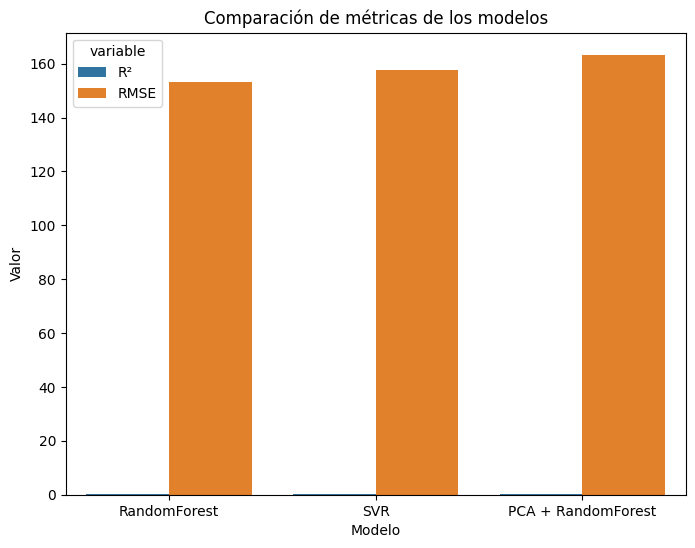

In [8]:
# Evaluar RandomForest
r2_rf, rmse_rf = evaluar_modelo(rf_model, X_train, X_test, y_train, y_test, "RandomForest")

# Evaluar SVR
r2_svr, rmse_svr = evaluar_modelo(svr_model, X_train, X_test, y_train, y_test, "SVR")

# Evaluar PCA + RandomForest
r2_pca_rf, rmse_pca_rf = evaluar_modelo(pca_rf_model, X_train, X_test, y_train, y_test, "PCA + RandomForest")

# Crear un DataFrame con las métricas de cada modelo
resultados = pd.DataFrame({
    'Modelo': ['RandomForest', 'SVR', 'PCA + RandomForest'],
    'R²': [r2_rf, r2_svr, r2_pca_rf],
    'RMSE': [rmse_rf, rmse_svr, rmse_pca_rf]
})

print("\nComparación de resultados:")
print(resultados)

# Visualizar los resultados
plt.figure(figsize=(8, 6))
sns.barplot(data=resultados.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
plt.title('Comparación de métricas de los modelos')
plt.ylabel('Valor')
plt.show()



In [21]:
# **9. Uso del modelo final para predicciones**

# Selección del modelo final (RandomForest en este caso) lo que es muy raro pero.. no entiendo
final_model = rf_model

# Ejemplo de predicción con nuevas observaciones (filas seleccionadas del conjunto de prueba)
new_samples = X_test.sample(5, random_state=0)
true_prices = y_test.loc[new_samples.index]
predicted_prices = final_model.predict(new_samples)

# Mostrar resultados de predicción
results = pd.DataFrame({
    'Precio real': true_prices,
    'Precio predicho': predicted_prices
})

print("\nPredicciones del modelo final para nuevas muestras:")
print(results)


Predicciones del modelo final para nuevas muestras:
       Precio real  Precio predicho
3439          75.0       125.138050
9206          75.0       117.267560
13058        225.0       404.918778
1195          90.0       117.267560
752          149.0       143.253688
